In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'Conv_VAE_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 2))
fixed_data, _ = next(iter(test_loader))

In [6]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [7]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [9]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
            
        self.fce = FullyConnected([32*2*2, latent_size*2])
        self.fcd = FullyConnected([latent_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.fce(flatten)
        self.mu, self.std = h.split(self.latent_size, dim=1)
        return self.mu, self.std
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def forward(self, x):
        mu, std = self.encode(x)
        if self.training:
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(h)
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size])
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu**2 + self.std**2 - 1 - torch.log(self.std**2)
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
        else:
            self.KLD = KLD.sum()
        self._loss = F.mse_loss(output, target, size_average=size_average)
        
        return self._loss + self.gamma*self.KLD

In [10]:
models = {
   # 'VAE10': Net(10, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4),
    'VAE2': Net(2, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4)
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [11]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [13]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data).data.numpy()
            fixed_gen = models[k].decode(fixed_z).data.numpy()
            plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses VAE2: 0.8739
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE2: 0.5339
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE2: 0.4347
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE2: 0.3957
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE2: 0.3493
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE2: 0.3446


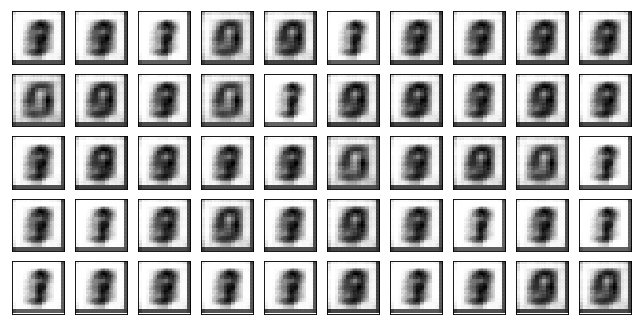

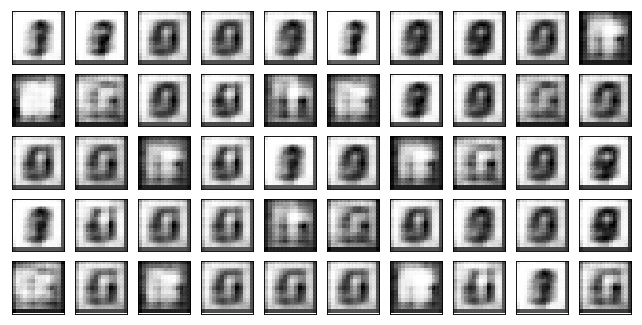

Test losses: VAE2: 0.3387/2.0083
Train Epoch: 2 [0/50000 (0%)]	Losses VAE2: 0.3390
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE2: 0.3053
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE2: 0.2786
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE2: 0.2539
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE2: 0.2604
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE2: 0.2390


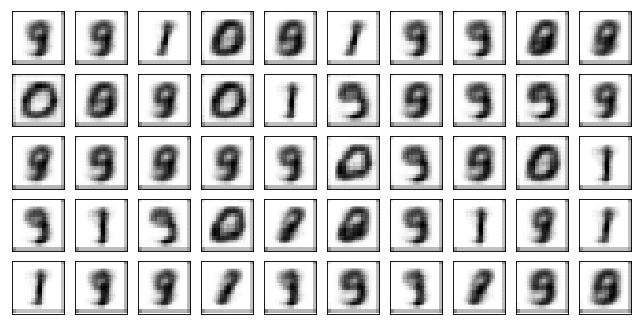

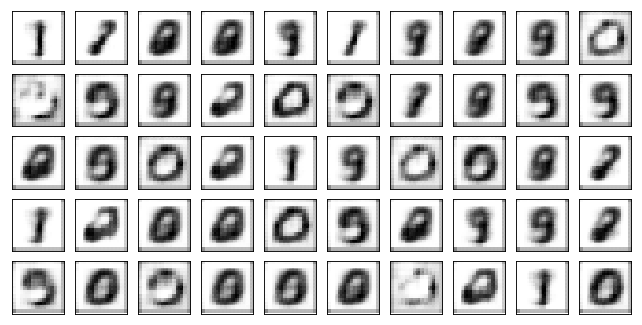

Test losses: VAE2: 0.2399/3.0596
Train Epoch: 3 [0/50000 (0%)]	Losses VAE2: 0.2512
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE2: 0.2364
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE2: 0.2286
Train Epoch: 3 [30000/50000 (60%)]	Losses VAE2: 0.2266
Train Epoch: 3 [40000/50000 (80%)]	Losses VAE2: 0.2191
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE2: 0.2183


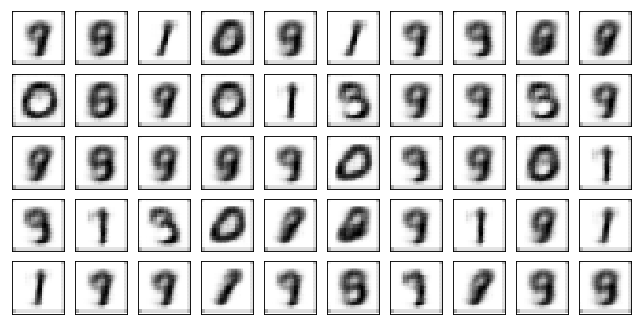

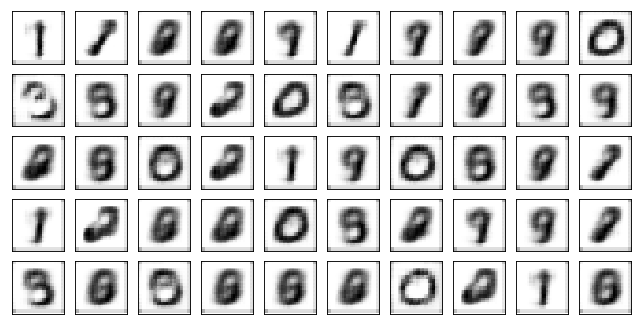

Test losses: VAE2: 0.2154/3.1157
Train Epoch: 4 [0/50000 (0%)]	Losses VAE2: 0.2083
Train Epoch: 4 [10000/50000 (20%)]	Losses VAE2: 0.2274
Train Epoch: 4 [20000/50000 (40%)]	Losses VAE2: 0.2478
Train Epoch: 4 [30000/50000 (60%)]	Losses VAE2: 0.2095
Train Epoch: 4 [40000/50000 (80%)]	Losses VAE2: 0.2107
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE2: 0.2039


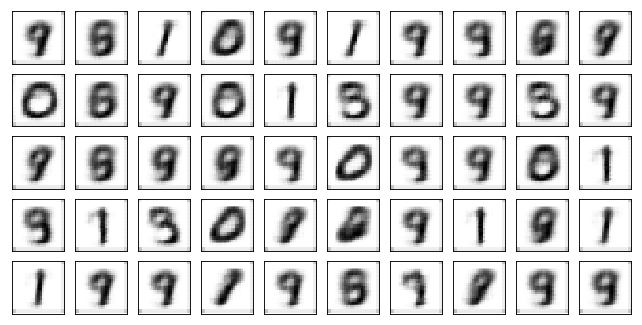

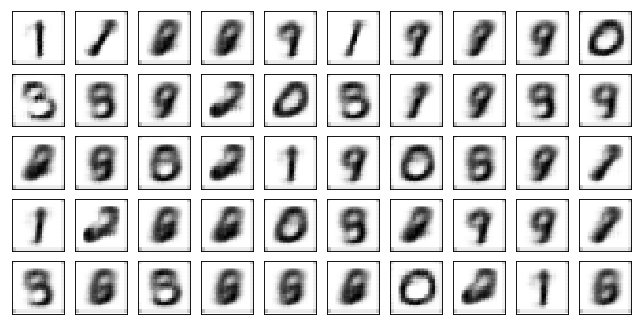

Test losses: VAE2: 0.2064/3.1521
Train Epoch: 5 [0/50000 (0%)]	Losses VAE2: 0.2314
Train Epoch: 5 [10000/50000 (20%)]	Losses VAE2: 0.2181
Train Epoch: 5 [20000/50000 (40%)]	Losses VAE2: 0.2069
Train Epoch: 5 [30000/50000 (60%)]	Losses VAE2: 0.2071
Train Epoch: 5 [40000/50000 (80%)]	Losses VAE2: 0.2086
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE2: 0.2146


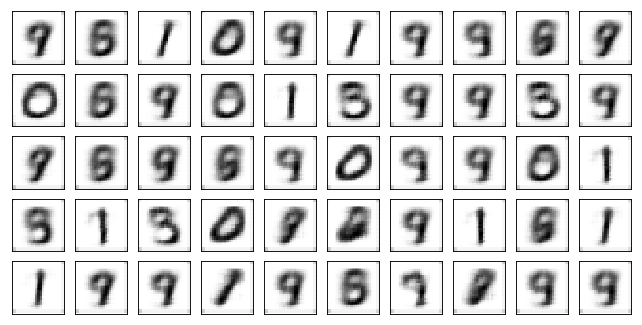

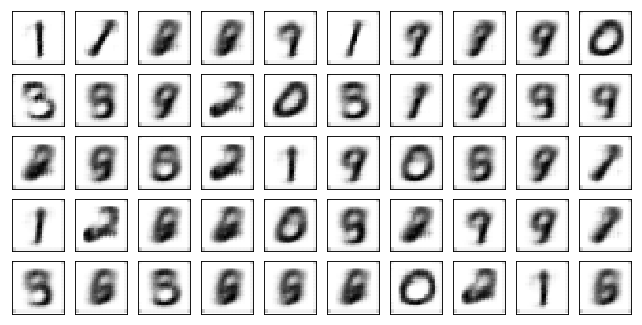

Test losses: VAE2: 0.2016/3.2624
Train Epoch: 6 [0/50000 (0%)]	Losses VAE2: 0.2061
Train Epoch: 6 [10000/50000 (20%)]	Losses VAE2: 0.2065
Train Epoch: 6 [20000/50000 (40%)]	Losses VAE2: 0.2240
Train Epoch: 6 [30000/50000 (60%)]	Losses VAE2: 0.2172
Train Epoch: 6 [40000/50000 (80%)]	Losses VAE2: 0.1883
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE2: 0.2177


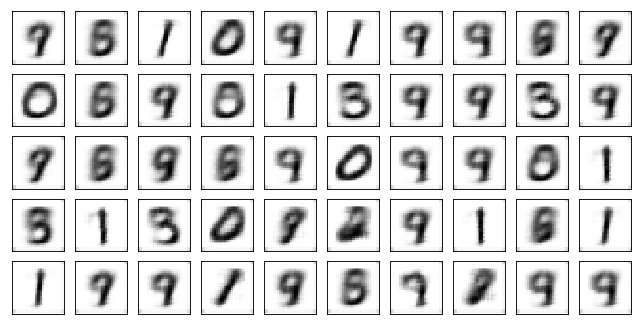

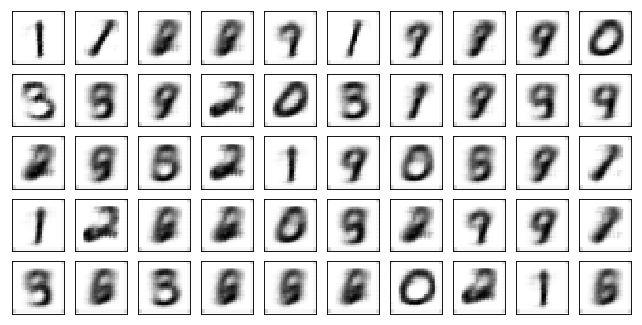

Test losses: VAE2: 0.1970/3.2047
Train Epoch: 7 [0/50000 (0%)]	Losses VAE2: 0.1826
Train Epoch: 7 [10000/50000 (20%)]	Losses VAE2: 0.1923
Train Epoch: 7 [20000/50000 (40%)]	Losses VAE2: 0.1991
Train Epoch: 7 [30000/50000 (60%)]	Losses VAE2: 0.1995
Train Epoch: 7 [40000/50000 (80%)]	Losses VAE2: 0.2131
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE2: 0.2171


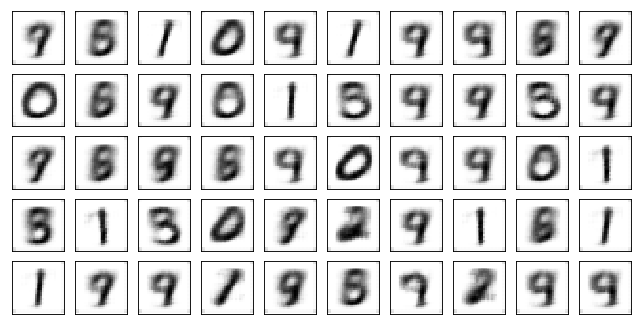

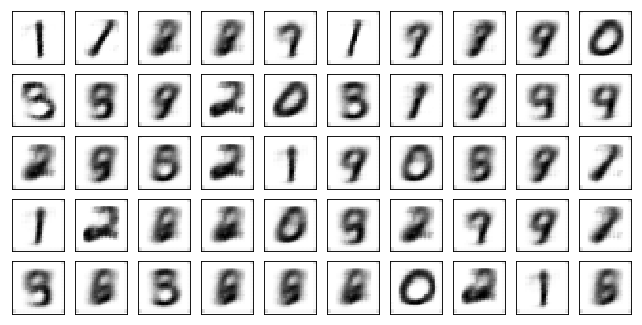

Test losses: VAE2: 0.1938/3.4882
Train Epoch: 8 [0/50000 (0%)]	Losses VAE2: 0.1956
Train Epoch: 8 [10000/50000 (20%)]	Losses VAE2: 0.1874
Train Epoch: 8 [20000/50000 (40%)]	Losses VAE2: 0.1892
Train Epoch: 8 [30000/50000 (60%)]	Losses VAE2: 0.2180
Train Epoch: 8 [40000/50000 (80%)]	Losses VAE2: 0.1711
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE2: 0.2101


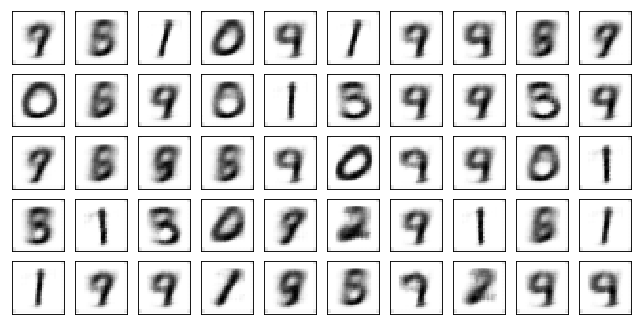

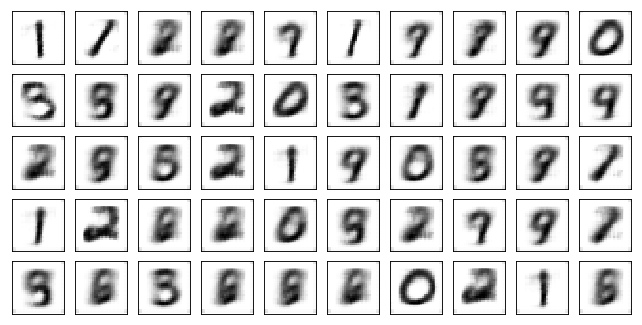

Test losses: VAE2: 0.1909/3.5439
Train Epoch: 9 [0/50000 (0%)]	Losses VAE2: 0.1955
Train Epoch: 9 [10000/50000 (20%)]	Losses VAE2: 0.1978
Train Epoch: 9 [20000/50000 (40%)]	Losses VAE2: 0.1792
Train Epoch: 9 [30000/50000 (60%)]	Losses VAE2: 0.2010
Train Epoch: 9 [40000/50000 (80%)]	Losses VAE2: 0.1997
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE2: 0.1869


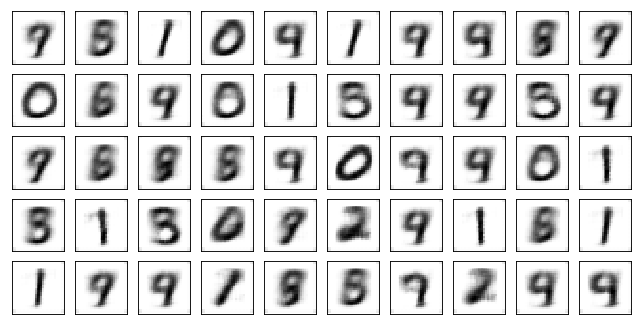

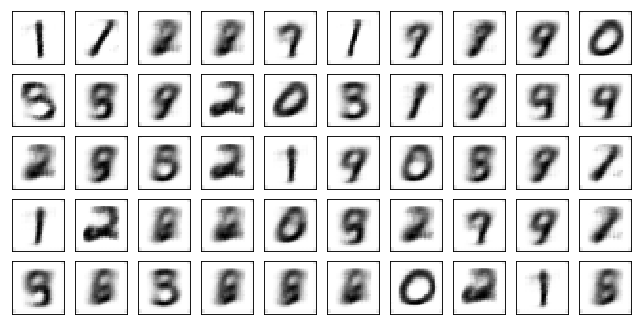

Test losses: VAE2: 0.1892/3.6446
Train Epoch: 10 [0/50000 (0%)]	Losses VAE2: 0.2125
Train Epoch: 10 [10000/50000 (20%)]	Losses VAE2: 0.1905
Train Epoch: 10 [20000/50000 (40%)]	Losses VAE2: 0.1941
Train Epoch: 10 [30000/50000 (60%)]	Losses VAE2: 0.2062
Train Epoch: 10 [40000/50000 (80%)]	Losses VAE2: 0.1908
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE2: 0.1906


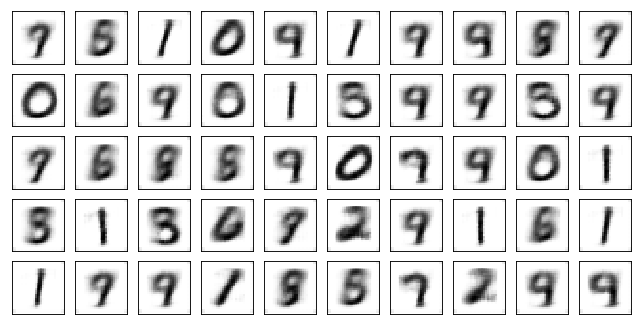

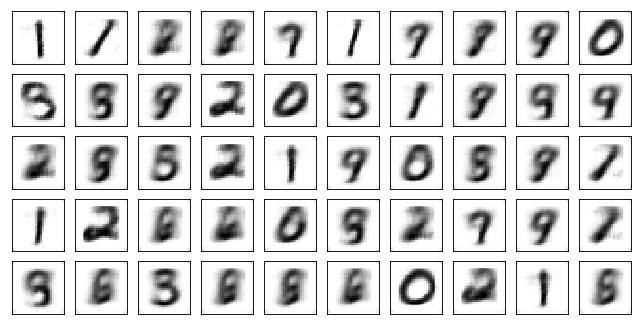

Test losses: VAE2: 0.1867/3.9985
Train Epoch: 11 [0/50000 (0%)]	Losses VAE2: 0.1925
Train Epoch: 11 [10000/50000 (20%)]	Losses VAE2: 0.1641
Train Epoch: 11 [20000/50000 (40%)]	Losses VAE2: 0.2022
Train Epoch: 11 [30000/50000 (60%)]	Losses VAE2: 0.1747
Train Epoch: 11 [40000/50000 (80%)]	Losses VAE2: 0.2022
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE2: 0.1811


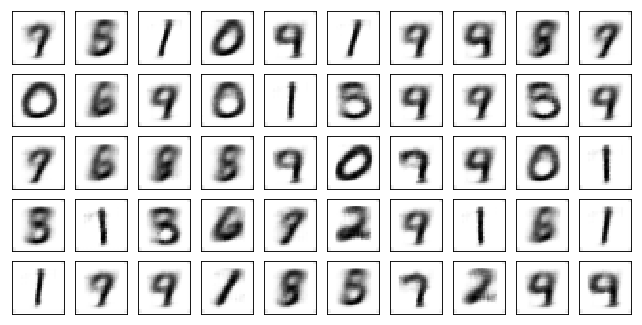

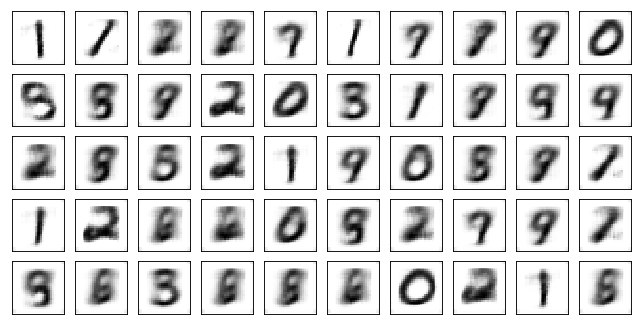

Test losses: VAE2: 0.1848/3.7221
Train Epoch: 12 [0/50000 (0%)]	Losses VAE2: 0.1694
Train Epoch: 12 [10000/50000 (20%)]	Losses VAE2: 0.1792
Train Epoch: 12 [20000/50000 (40%)]	Losses VAE2: 0.1929
Train Epoch: 12 [30000/50000 (60%)]	Losses VAE2: 0.1980
Train Epoch: 12 [40000/50000 (80%)]	Losses VAE2: 0.1984
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE2: 0.1840


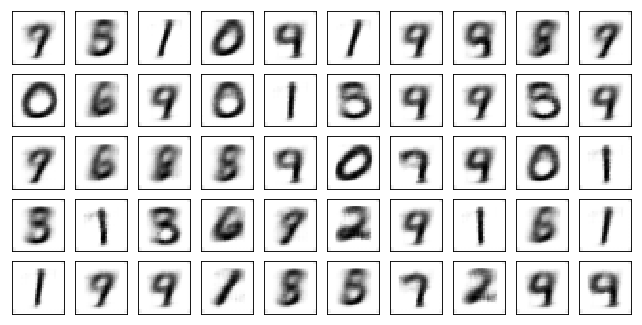

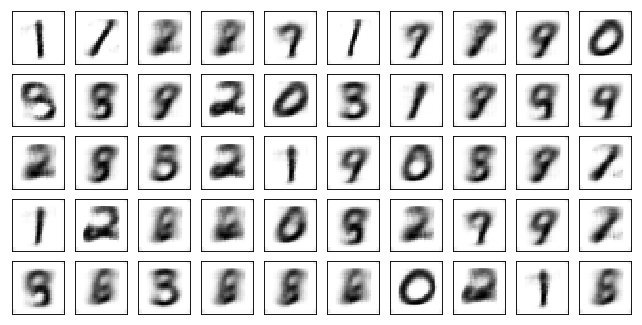

Test losses: VAE2: 0.1839/3.7601
Train Epoch: 13 [0/50000 (0%)]	Losses VAE2: 0.1696
Train Epoch: 13 [10000/50000 (20%)]	Losses VAE2: 0.2115
Train Epoch: 13 [20000/50000 (40%)]	Losses VAE2: 0.1801
Train Epoch: 13 [30000/50000 (60%)]	Losses VAE2: 0.1910
Train Epoch: 13 [40000/50000 (80%)]	Losses VAE2: 0.1990
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE2: 0.1953


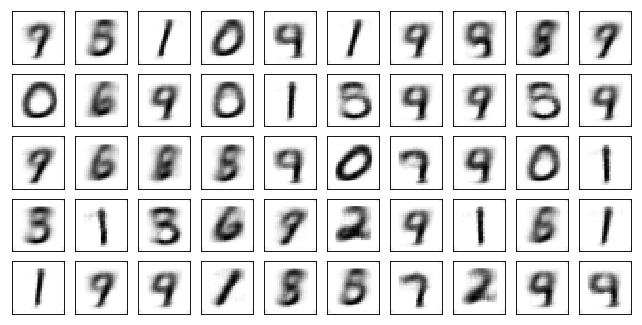

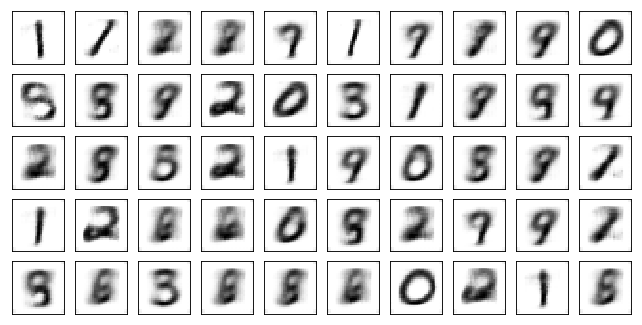

Test losses: VAE2: 0.1827/3.8374
Train Epoch: 14 [0/50000 (0%)]	Losses VAE2: 0.1902
Train Epoch: 14 [10000/50000 (20%)]	Losses VAE2: 0.2012
Train Epoch: 14 [20000/50000 (40%)]	Losses VAE2: 0.1892
Train Epoch: 14 [30000/50000 (60%)]	Losses VAE2: 0.1981
Train Epoch: 14 [40000/50000 (80%)]	Losses VAE2: 0.1825
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE2: 0.1770


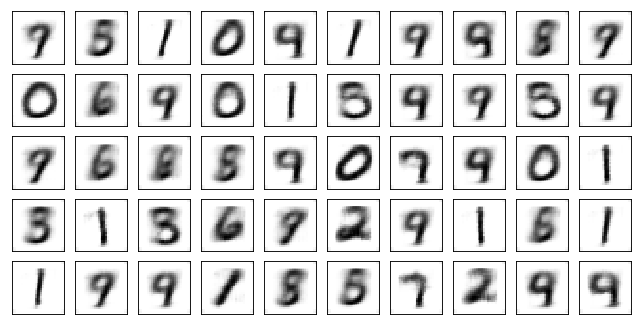

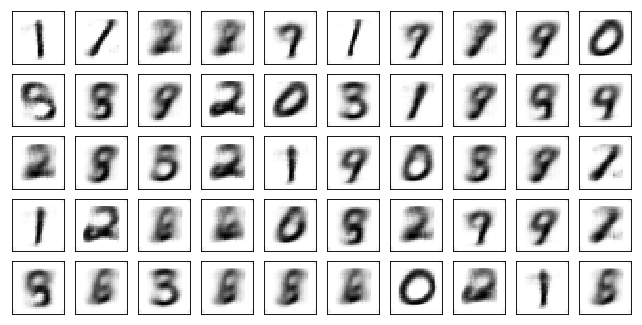

Test losses: VAE2: 0.1807/4.0218
Train Epoch: 15 [0/50000 (0%)]	Losses VAE2: 0.1957
Train Epoch: 15 [10000/50000 (20%)]	Losses VAE2: 0.1843
Train Epoch: 15 [20000/50000 (40%)]	Losses VAE2: 0.1772
Train Epoch: 15 [30000/50000 (60%)]	Losses VAE2: 0.2117
Train Epoch: 15 [40000/50000 (80%)]	Losses VAE2: 0.1842
Train Epoch: 15 [50000/50000 (100%)]	Losses VAE2: 0.1717


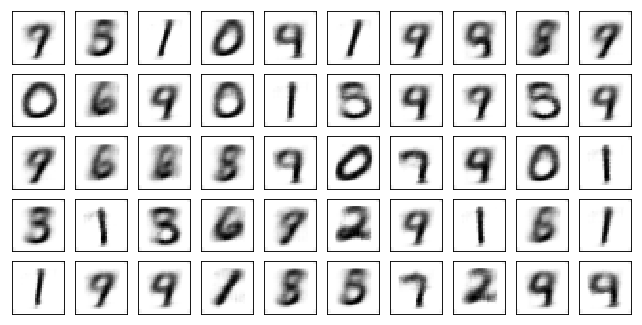

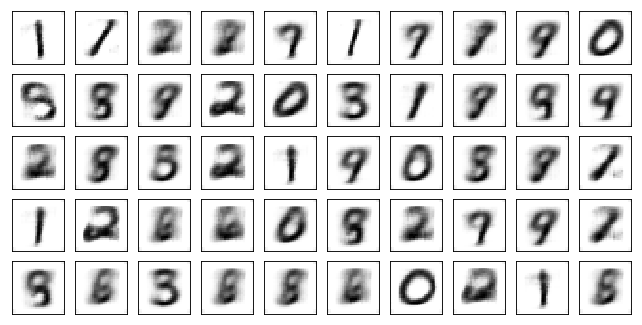

Test losses: VAE2: 0.1802/3.7918
Train Epoch: 16 [0/50000 (0%)]	Losses VAE2: 0.2043
Train Epoch: 16 [10000/50000 (20%)]	Losses VAE2: 0.1956
Train Epoch: 16 [20000/50000 (40%)]	Losses VAE2: 0.2008
Train Epoch: 16 [30000/50000 (60%)]	Losses VAE2: 0.1775
Train Epoch: 16 [40000/50000 (80%)]	Losses VAE2: 0.1959
Train Epoch: 16 [50000/50000 (100%)]	Losses VAE2: 0.1831


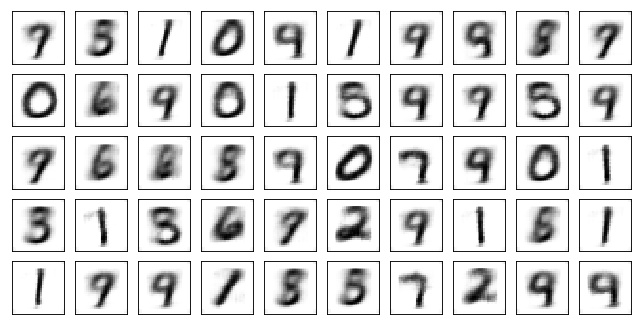

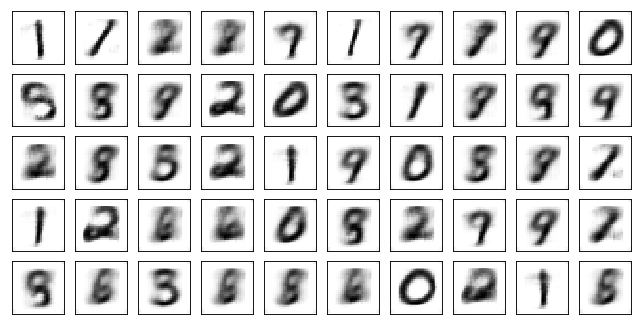

Test losses: VAE2: 0.1788/4.0877
Train Epoch: 17 [0/50000 (0%)]	Losses VAE2: 0.1843
Train Epoch: 17 [10000/50000 (20%)]	Losses VAE2: 0.1816
Train Epoch: 17 [20000/50000 (40%)]	Losses VAE2: 0.1715
Train Epoch: 17 [30000/50000 (60%)]	Losses VAE2: 0.1968
Train Epoch: 17 [40000/50000 (80%)]	Losses VAE2: 0.1901
Train Epoch: 17 [50000/50000 (100%)]	Losses VAE2: 0.1780


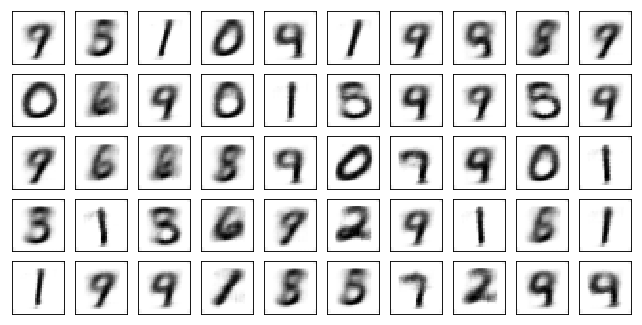

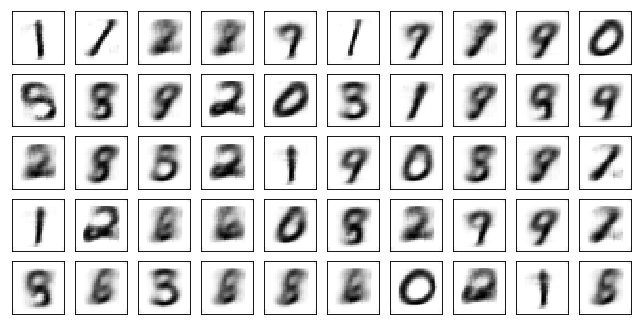

Test losses: VAE2: 0.1785/3.7954
Train Epoch: 18 [0/50000 (0%)]	Losses VAE2: 0.1908
Train Epoch: 18 [10000/50000 (20%)]	Losses VAE2: 0.1889
Train Epoch: 18 [20000/50000 (40%)]	Losses VAE2: 0.1834
Train Epoch: 18 [30000/50000 (60%)]	Losses VAE2: 0.1903
Train Epoch: 18 [40000/50000 (80%)]	Losses VAE2: 0.1831
Train Epoch: 18 [50000/50000 (100%)]	Losses VAE2: 0.1827


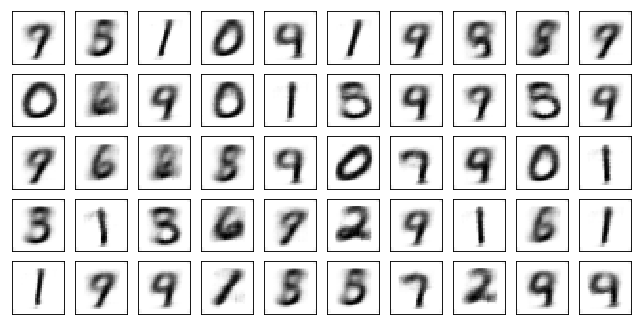

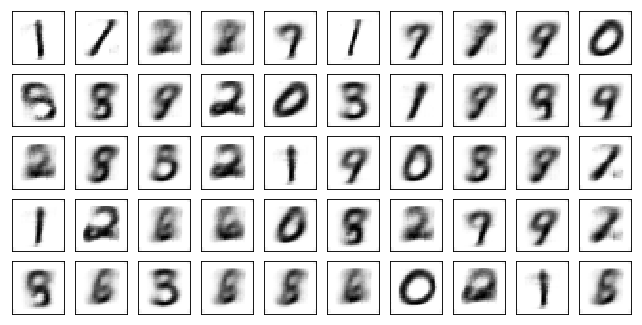

Test losses: VAE2: 0.1776/3.9209
Train Epoch: 19 [0/50000 (0%)]	Losses VAE2: 0.1895
Train Epoch: 19 [10000/50000 (20%)]	Losses VAE2: 0.1855
Train Epoch: 19 [20000/50000 (40%)]	Losses VAE2: 0.1819
Train Epoch: 19 [30000/50000 (60%)]	Losses VAE2: 0.1681
Train Epoch: 19 [40000/50000 (80%)]	Losses VAE2: 0.1802
Train Epoch: 19 [50000/50000 (100%)]	Losses VAE2: 0.1816


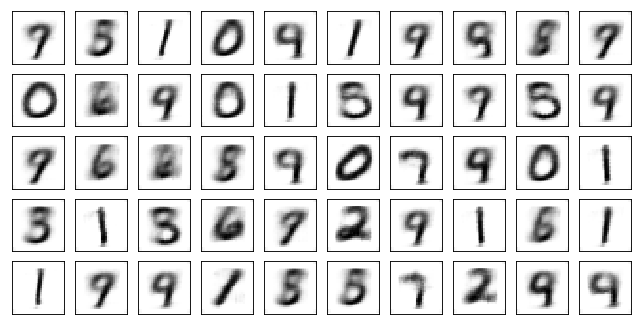

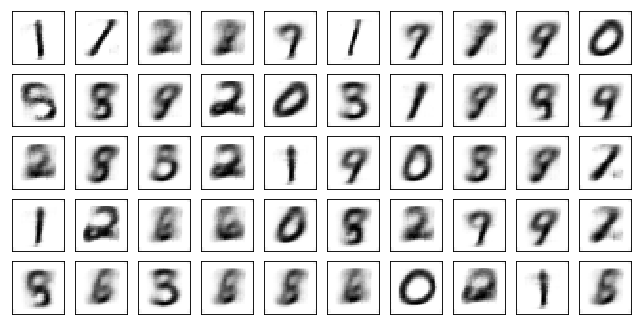

Test losses: VAE2: 0.1763/4.2220
Train Epoch: 20 [0/50000 (0%)]	Losses VAE2: 0.1843
Train Epoch: 20 [10000/50000 (20%)]	Losses VAE2: 0.1897
Train Epoch: 20 [20000/50000 (40%)]	Losses VAE2: 0.1868
Train Epoch: 20 [30000/50000 (60%)]	Losses VAE2: 0.1735
Train Epoch: 20 [40000/50000 (80%)]	Losses VAE2: 0.1825
Train Epoch: 20 [50000/50000 (100%)]	Losses VAE2: 0.1875


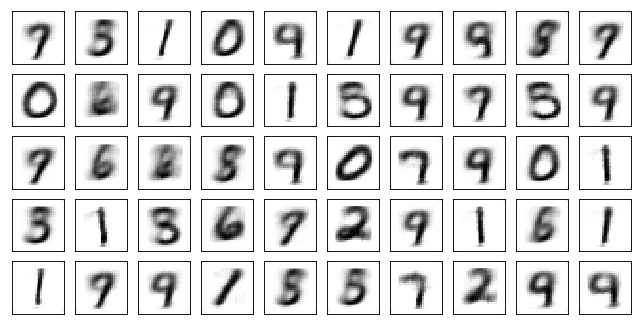

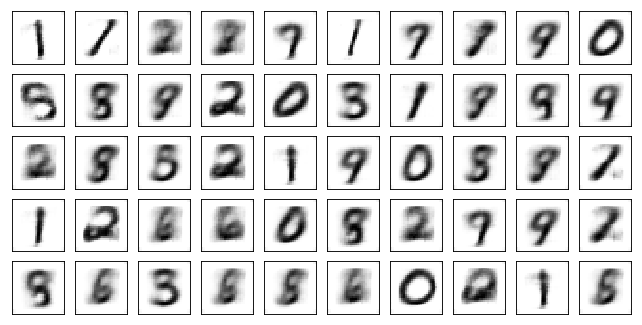

Test losses: VAE2: 0.1758/4.1425
Train Epoch: 21 [0/50000 (0%)]	Losses VAE2: 0.1883
Train Epoch: 21 [10000/50000 (20%)]	Losses VAE2: 0.1738
Train Epoch: 21 [20000/50000 (40%)]	Losses VAE2: 0.1880
Train Epoch: 21 [30000/50000 (60%)]	Losses VAE2: 0.1752
Train Epoch: 21 [40000/50000 (80%)]	Losses VAE2: 0.1675
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE2: 0.1850


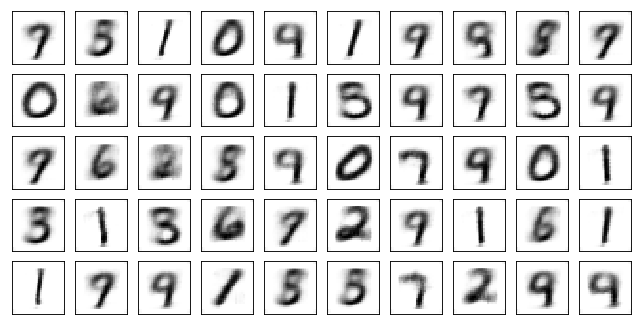

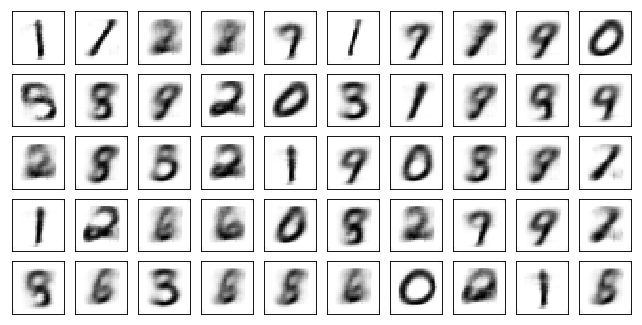

Test losses: VAE2: 0.1750/4.0461
Train Epoch: 22 [0/50000 (0%)]	Losses VAE2: 0.1975
Train Epoch: 22 [10000/50000 (20%)]	Losses VAE2: 0.1802
Train Epoch: 22 [20000/50000 (40%)]	Losses VAE2: 0.1626
Train Epoch: 22 [30000/50000 (60%)]	Losses VAE2: 0.1753
Train Epoch: 22 [40000/50000 (80%)]	Losses VAE2: 0.1836
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE2: 0.1903


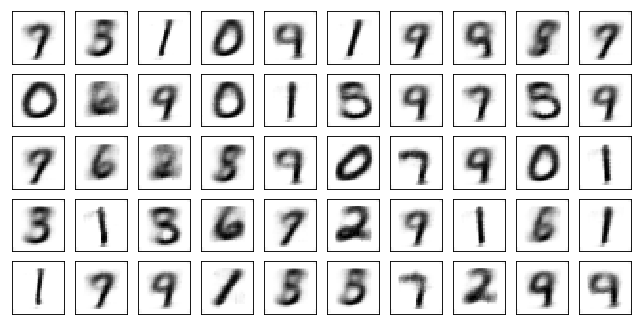

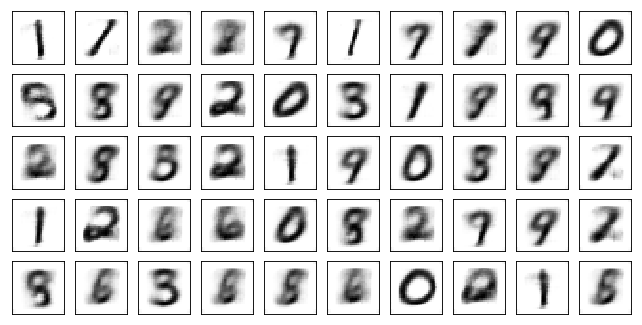

Test losses: VAE2: 0.1746/4.1200
Train Epoch: 23 [0/50000 (0%)]	Losses VAE2: 0.1753
Train Epoch: 23 [10000/50000 (20%)]	Losses VAE2: 0.1876
Train Epoch: 23 [20000/50000 (40%)]	Losses VAE2: 0.2045
Train Epoch: 23 [30000/50000 (60%)]	Losses VAE2: 0.1671
Train Epoch: 23 [40000/50000 (80%)]	Losses VAE2: 0.1685
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE2: 0.1928


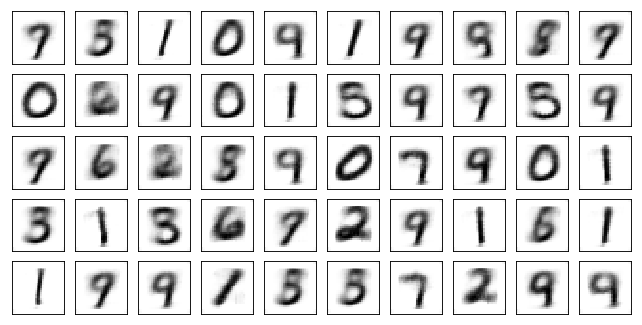

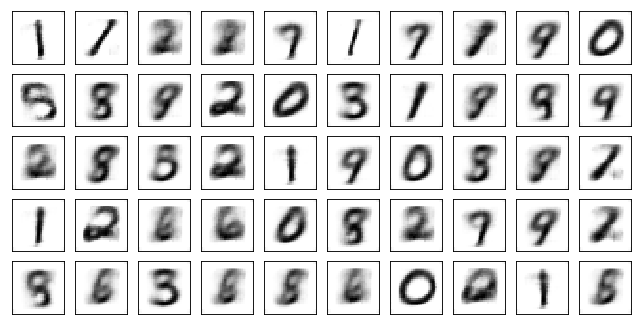

Test losses: VAE2: 0.1739/4.2281
Train Epoch: 24 [0/50000 (0%)]	Losses VAE2: 0.1672
Train Epoch: 24 [10000/50000 (20%)]	Losses VAE2: 0.1735
Train Epoch: 24 [20000/50000 (40%)]	Losses VAE2: 0.1794
Train Epoch: 24 [30000/50000 (60%)]	Losses VAE2: 0.1647
Train Epoch: 24 [40000/50000 (80%)]	Losses VAE2: 0.1869
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE2: 0.1698


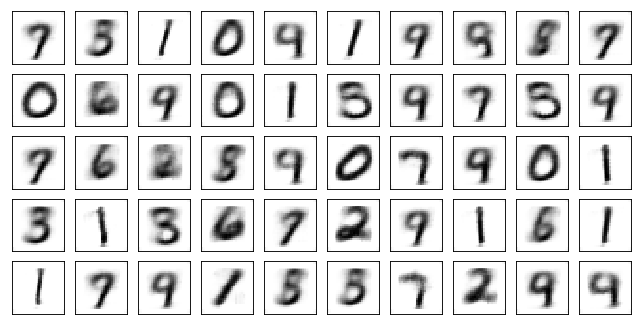

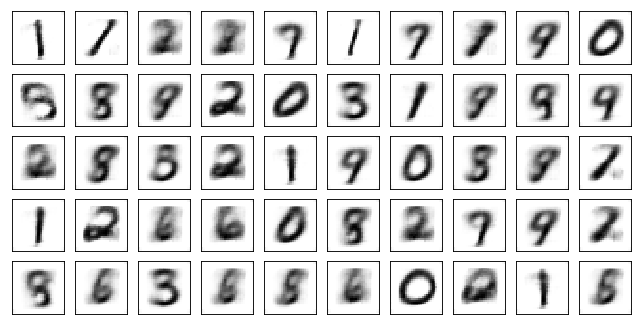

Test losses: VAE2: 0.1734/4.2011
Train Epoch: 25 [0/50000 (0%)]	Losses VAE2: 0.1810
Train Epoch: 25 [10000/50000 (20%)]	Losses VAE2: 0.1676
Train Epoch: 25 [20000/50000 (40%)]	Losses VAE2: 0.1751
Train Epoch: 25 [30000/50000 (60%)]	Losses VAE2: 0.1924
Train Epoch: 25 [40000/50000 (80%)]	Losses VAE2: 0.1780
Train Epoch: 25 [50000/50000 (100%)]	Losses VAE2: 0.1933


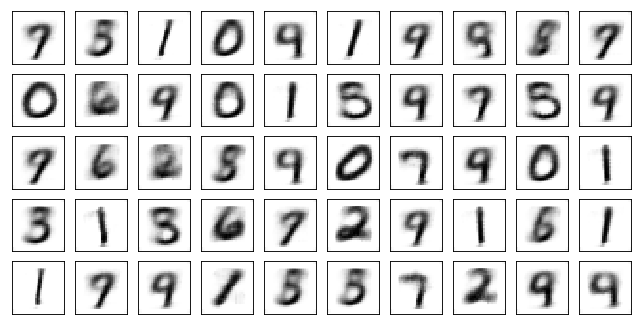

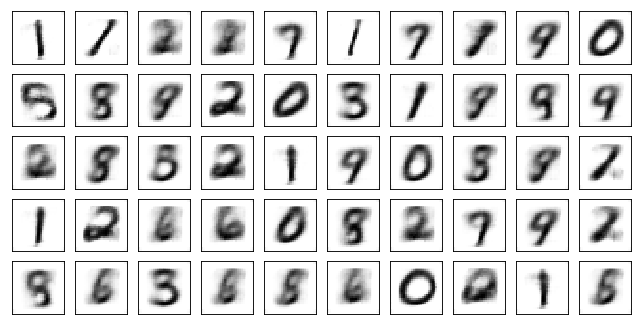

Test losses: VAE2: 0.1730/4.0360
Train Epoch: 26 [0/50000 (0%)]	Losses VAE2: 0.1819
Train Epoch: 26 [10000/50000 (20%)]	Losses VAE2: 0.1794
Train Epoch: 26 [20000/50000 (40%)]	Losses VAE2: 0.1724
Train Epoch: 26 [30000/50000 (60%)]	Losses VAE2: 0.1822
Train Epoch: 26 [40000/50000 (80%)]	Losses VAE2: 0.1666
Train Epoch: 26 [50000/50000 (100%)]	Losses VAE2: 0.1715


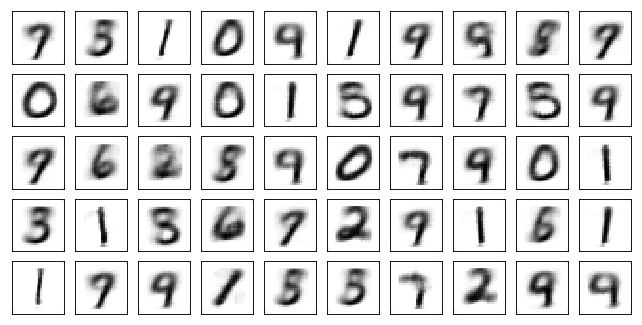

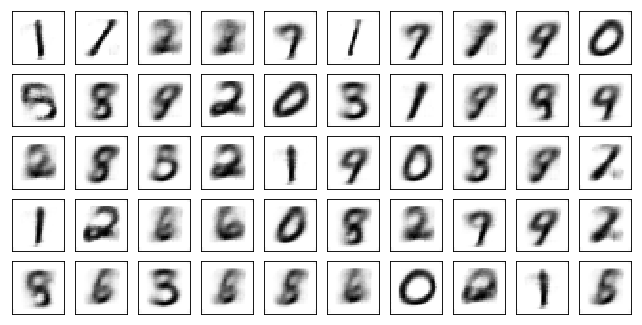

Test losses: VAE2: 0.1725/4.1945
Train Epoch: 27 [0/50000 (0%)]	Losses VAE2: 0.1777
Train Epoch: 27 [10000/50000 (20%)]	Losses VAE2: 0.1832
Train Epoch: 27 [20000/50000 (40%)]	Losses VAE2: 0.1735
Train Epoch: 27 [30000/50000 (60%)]	Losses VAE2: 0.1687
Train Epoch: 27 [40000/50000 (80%)]	Losses VAE2: 0.1677
Train Epoch: 27 [50000/50000 (100%)]	Losses VAE2: 0.1746


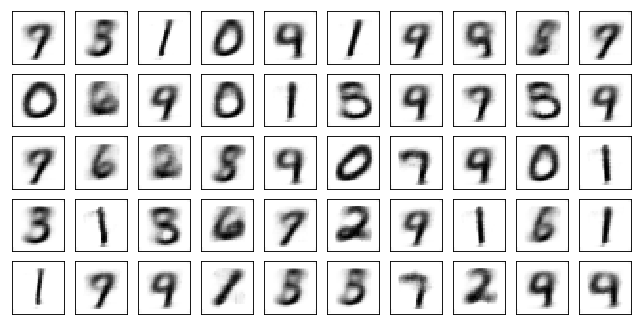

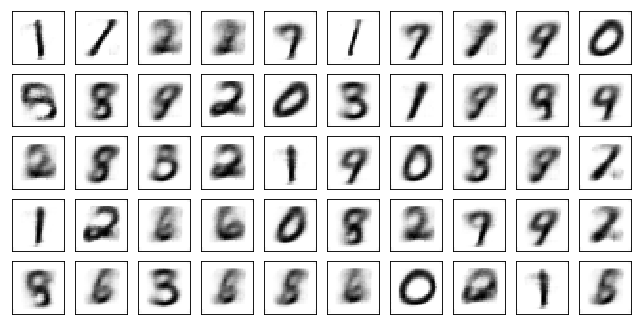

Test losses: VAE2: 0.1724/4.2638
Train Epoch: 28 [0/50000 (0%)]	Losses VAE2: 0.1906
Train Epoch: 28 [10000/50000 (20%)]	Losses VAE2: 0.1846
Train Epoch: 28 [20000/50000 (40%)]	Losses VAE2: 0.2010
Train Epoch: 28 [30000/50000 (60%)]	Losses VAE2: 0.1675
Train Epoch: 28 [40000/50000 (80%)]	Losses VAE2: 0.1988
Train Epoch: 28 [50000/50000 (100%)]	Losses VAE2: 0.1677


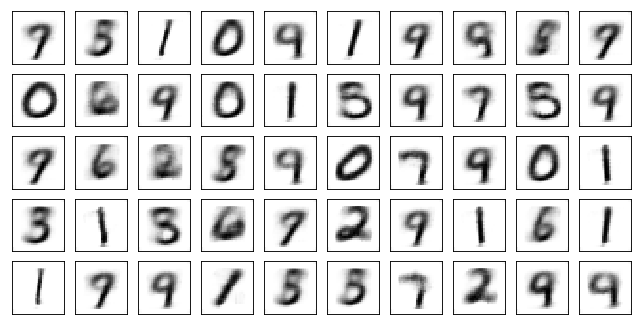

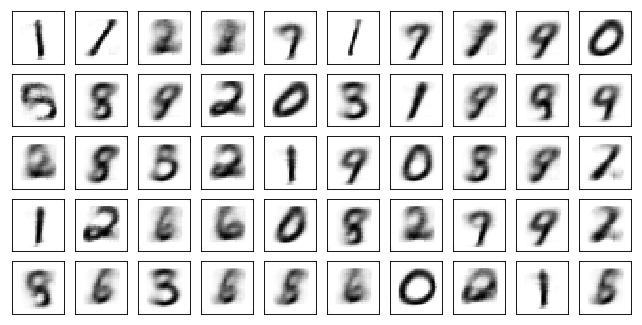

Test losses: VAE2: 0.1718/4.2381
Train Epoch: 29 [0/50000 (0%)]	Losses VAE2: 0.1731
Train Epoch: 29 [10000/50000 (20%)]	Losses VAE2: 0.1906
Train Epoch: 29 [20000/50000 (40%)]	Losses VAE2: 0.1789
Train Epoch: 29 [30000/50000 (60%)]	Losses VAE2: 0.1728
Train Epoch: 29 [40000/50000 (80%)]	Losses VAE2: 0.1792
Train Epoch: 29 [50000/50000 (100%)]	Losses VAE2: 0.1746


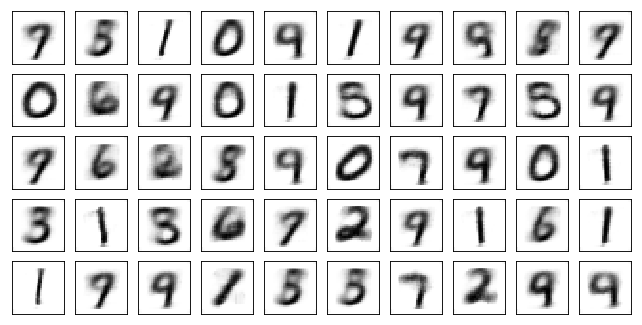

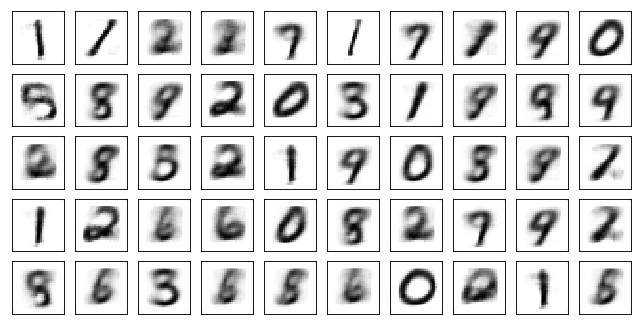

Test losses: VAE2: 0.1712/4.2496
Train Epoch: 30 [0/50000 (0%)]	Losses VAE2: 0.1748
Train Epoch: 30 [10000/50000 (20%)]	Losses VAE2: 0.1721
Train Epoch: 30 [20000/50000 (40%)]	Losses VAE2: 0.1564
Train Epoch: 30 [30000/50000 (60%)]	Losses VAE2: 0.1696
Train Epoch: 30 [40000/50000 (80%)]	Losses VAE2: 0.1834
Train Epoch: 30 [50000/50000 (100%)]	Losses VAE2: 0.1898


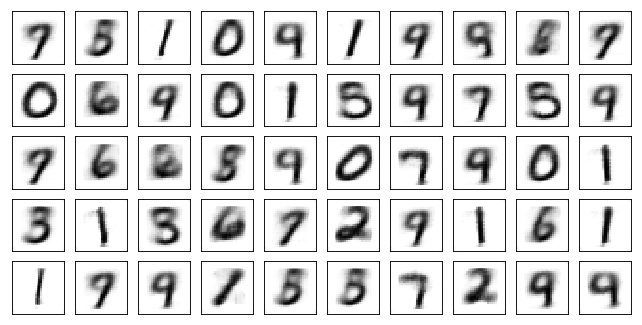

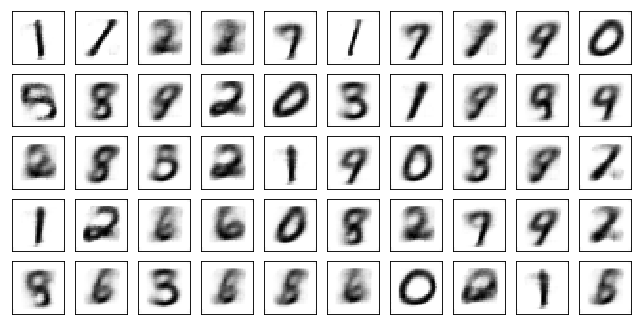

Test losses: VAE2: 0.1714/4.3649


In [14]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)

In [15]:
torch.save(models['VAE2'], './vae_2')

/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't r

## Вывод результатов

In [21]:
model = torch.load('./vae_2')

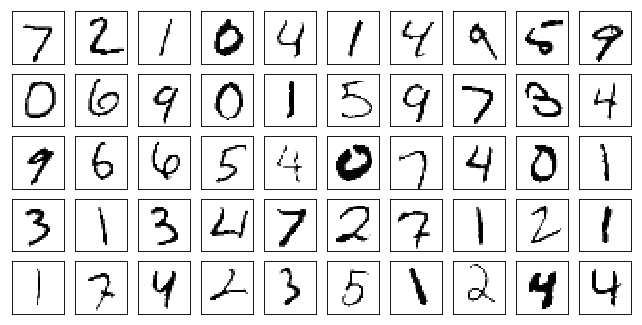

In [22]:
data, _ = next(iter(test_loader))
to_plot = data.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (5, 10))

## Визуализация латентного слоя

In [150]:
data, _ = next(iter(test_loader))
plot_data = [np.empty((0,2)) for _ in range(0,10)]

with torch.no_grad():
    for data, cl in test_loader:
        mu, std = model.encode(data)        
        for vals in zip(mu, cl):           
            idx = vals[1].detach().numpy() 
            val = vals[0].detach().numpy()            
            plot_data[idx] = np.vstack([ plot_data[idx], (val[0],val[1]) ])
        
for idx in range(0,10):        
    print ('class "{}", shape {}'.format(idx,plot_data[idx].shape))      


class "0", shape (980, 2)
class "1", shape (1135, 2)
class "2", shape (1032, 2)
class "3", shape (1010, 2)
class "4", shape (982, 2)
class "5", shape (892, 2)
class "6", shape (958, 2)
class "7", shape (1028, 2)
class "8", shape (974, 2)
class "9", shape (1009, 2)


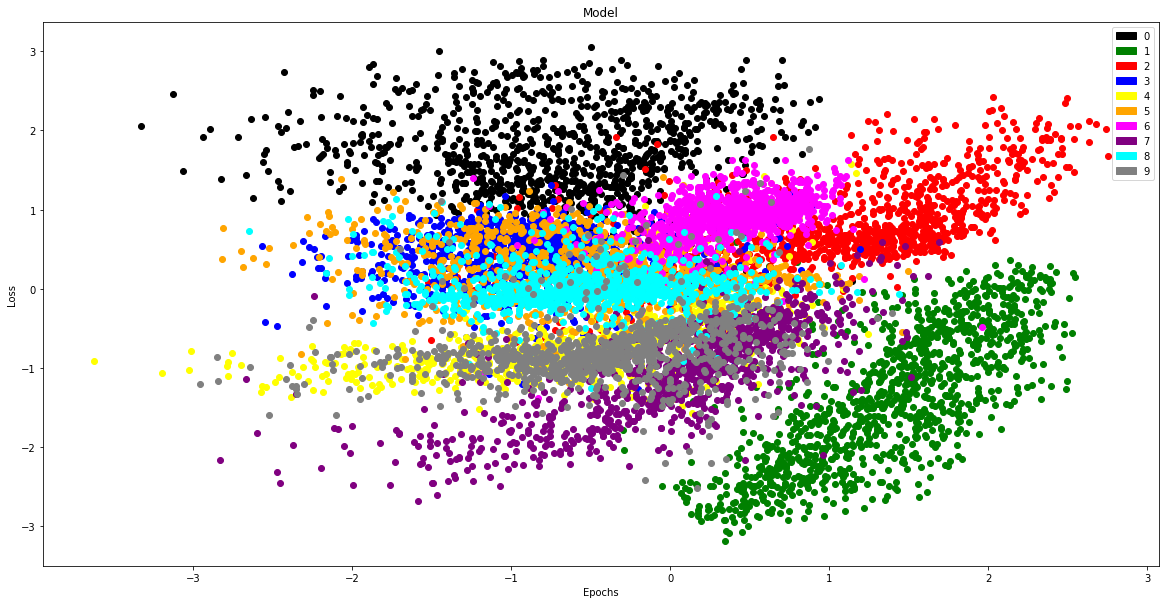

In [104]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.set_title("VAE latent layer visualization")
colors = ['black','green','red','blue','yellow','orange','magenta','purple','cyan','gray']
patch = []
for cl in range(0,10):
    patch.append(mpatches.Patch(color=colors[cl], label=cl))
    for sample in plot_data[cl]: 
        ax.plot(sample[0], sample[1], color=colors[cl], marker='o')

ax.legend(handles=patch)

## Визуализация значений из латентного слоя по классам

In [168]:
def random_sample(cl):
    rnd = torch.randint(low=0, high=len(plot_data[cl]), size=(1,0))[0]
    rnd = int(rnd.detach().numpy())
    return plot_data[cl][rnd]

In [172]:
def plot_random_sample(cl):
    sm = random_sample(cl)
    sample = torch.Tensor(sm)
    img = model.decode(sample)
    to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
    plot_mnist(to_plot, (1, 1))
    

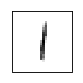

In [173]:
plot_random_sample(1)

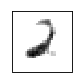

In [174]:
plot_random_sample(2)

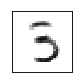

In [177]:
plot_random_sample(3)

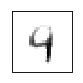

In [178]:
plot_random_sample(4)

## Визуализация перехода из одного класса в другой

In [159]:
def show_transition(cl_1, cl_2):
    begin = random_sample(cl_1)
    end = random_sample(cl_2)

    with torch.no_grad():

        x1,y1 = begin
        x2,y2 = end

        points = []
        decoded = torch.empty((0,0,0,0))
        dec_to_plot = []
        step = (x2 - x1) / 15
        for idx in range(0,15):
            x = x1 + step*idx
            y = (x2*y1 - x1*y2 - (y1-y2)*x) / (x2 - x1) # формула прямой по 2 точкам
            sample = torch.Tensor([x,y])
            img = model.decode(sample)
            decoded = torch.cat((decoded, img), 0)

        dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
        plot_mnist(dec_to_plot, (1, 15))    


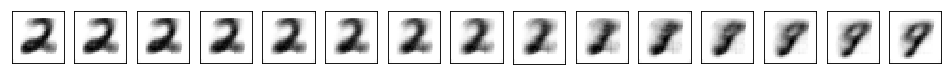

In [162]:
show_transition(2, 9)

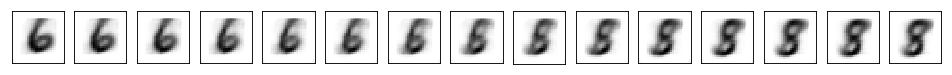

In [163]:
show_transition(6, 8)

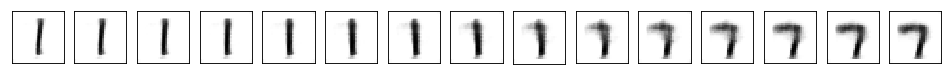

In [164]:
show_transition(1, 7)